# Пайплайн для DS<a class="anchor" id="zeroth-bullet"></a>

Этот пайплайн содержит несколько универсальных инструментов, но не заменяет человека. На каждом шаге стандартного алгоритма нужно принимать решения в зависимости от данных: что удалить, а что оставить, какие значения заменить и на что. Пайплайн содержит функции для ускорения реализации принятых решений и частные примеры, которые иллюстрируют действия, но не несут большого аналитического смысла.

**1 Анализ**

1.1 [Загрузка данных](#first-bullet)
- считать csv
- вывести head и info
- посмотреть на пропуски и дубликаты
- изучить распределения числовых признаков
- посмотреть корреляции
- изучить категориальные признаки


1.2 [Предобработка данных](#second-bullet)
- заполнить пропуски
- обработать аномальные значения
- изменить типы данных


1.3 [Подготовка признаков](#third-bullet)
- закодировать категориальные
- масштабировать и нормализовать числовые
- добавить новые признаки
- оценить важность признаков
    
**2 [Пайплайн](#fourth-bullet)**


**3 Обучение**
    
3.1 [Предобработка](#fifth-bullet)

3.2 [Регрессия](#sixth-bullet)

3.3 [Классификация](#seventh-bullet)

Загрузим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np

#Для графиков
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(context='talk', style='whitegrid', palette='muted')
from sklearn.manifold import TSNE

#Q-Q-plot
import statsmodels.api as sm

#Для поиска категориальных столбцов
from pandas.api.types import is_categorical_dtype

#Для подготовки числовых и категориальных признаков
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler

#Для преобразования Бокса-Кокса
from scipy.stats import boxcox

#Для создания новых признаков
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#Для поиска гиперпараметров и оценки моделей
import optuna
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# 1 Анализ

## 1.1 Загрузка данных <a class="anchor" id="first-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Когда мы пытаемся вывести на экран несколько строк большого датафрейма, часть столбцов заменяется на многоточие, поэтому зрительно оценить, в каком виде представлены данные, оказывается сложно. Функция print_df решает эту проблему: датафрейм выводится на экран последовательными блоками из заданного количества столбцов. Функцию можно использовать и для вывода большого количества строк, тогда is_row=True.

In [2]:
def print_df(df, num, is_row=False):
    '''
    Выводит датафрейм последовательно частями по заданному количеству столбцов или строк.
    По умолчанию выводит по столбцам.
    '''
    if is_row:
        for i in range(0, df.shape[0], num):
            display(df.iloc[i:i+num, :])
    else:
        for i in range(0, df.shape[1], num):
            display(df.iloc[:, i:i+num])

Начало любого проекта: загрузить файл, вывести несколько первых строк, посмотреть info, оценить NaN, проверить наличие дубликатов. Аргументы как для pd.read_csv - на выходе датафрейм и всё описание.

In [3]:
def read_file(**kwargs):
    '''
    Принимает аргументы для pd.read_csv, возвращает датафрейм.
    Выводит на экран первые 10 строк датафрейма блоками по 10 столбцов.
    Выводи df.info().
    Если есть пропущенные значения, 
    выводит их количество и процент пропусков для каждого столбца блоками по 50 строк в порядке убывания.
    Выводит количество дубликатов.
    '''
    
    df = pd.read_csv(**kwargs)
    
    print_df(df.head(10), 10)
    
    print(df.info())
    
    if df.isna().sum().sum() != 0:
        df_nans = (df.isna().sum() #Считаем сколько пропусков в каждом столбце
                   .pipe(lambda x: x.loc[x != 0]) #Оставляем только те столбцы, в которых есть пропуски
                   .sort_values(ascending=False) #Сортируем по убыванию
                   .to_frame('num_nan') 
                  )
        df_nans['rate'] = (df_nans['num_nan'] / df.shape[0]).map(lambda x: '{:.2%}'.format(x))
        
        print_df(df_nans, 50, is_row=True)
        
    print()
    print('Количество повторяющихся строк:', df.duplicated().sum())
    
    return df

Для числовых признаков важно оценить распределение значений: диапазон, нормальность, выбросы. Функция num_info даёт визуальное представление о данных.

In [4]:
def num_info(df, cols=None):
    '''
    Выводит информацию о числовых данных: describe, kde, boxplot, Q-Q-plot.
    По умолчанию - для всех числовых столбцов. 
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]

    df_descr = round(df[cols].describe(), 2)
    
    f, ax = plt.subplots(len(cols), 4, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
    f.set_figheight(6 * len(cols))
    f.set_figwidth(20)
    
    for i, col in enumerate(cols):
        if len(cols) == 1:
            ax_xy = [ax[0],ax[1],ax[2],ax[3]]
        else:
            ax_xy = [ax[i,0],ax[i,1],ax[i,2],ax[i,3]]
        
        the_table = ax_xy[0].table(
            #Содержимое таблицы в виде списка списков строк
            cellText = [list(x) for x in df_descr.loc[:,col].values.reshape(df_descr.shape[0],1).astype('str')],
            rowLabels = list(df_descr.index),
            colLabels = [col],
            loc = 'upper center',
            colWidths = [0.8],
        )
        the_table.scale(1, 2)
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(16)
        ax_xy[0].grid(False)
        ax_xy[0].axis('off')

        sns.kdeplot(
            x = col,
            data = df,
            shade = True,
            linewidth = 3,
            ax = ax_xy[1]
        )
    
        sns.boxplot(
            x = col,
            data = df,
            orient = 'h',
            ax = ax_xy[2]
        )
        sm.qqplot(df[df[col].notna()][col], line='45', fit=True, ax=ax_xy[3])

    plt.show()

Функция num_corr показывает матрицу корреляций и визуализирует её с помощью heatmap. Кроме того, на экран выводится pairplot, для которого можно задать hue.

In [5]:
def num_corr(df, cols=None, hue=None):
    '''
    Выводит матрицу корреляций в виде таблицы и heatmap.
    Печатает pairplot. Если указано значение hue, то группирует по этому столбцу.
    По умолчанию работает для всех числовых столбцов. 
    (Для больших датасетов матрица корреляций может быть выведена не полностью, 
    а построение графиков займёт много времени.)
    
    df - dataframe
    cols - список числовых столбцов, например: ['num_col0','num_col1','num_col2']
    hue - имя столбца для группировки pairplot, например 'cat_col4'
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
    
    corr = round(df[cols].corr(), 2)
    display(corr)
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(corr, mask=mask, center=0, vmax=1, vmin=-1, square=True, annot=True, cmap='YlGnBu')
    plt.show()
    
    sns.pairplot(data=df, x_vars=cols, y_vars=cols, corner=True, diag_kind='kde', hue=hue)
    plt.tight_layout()
    plt.show()

Для категориальных признаков важно посмотреть количество и варианты значений. В функцию можно передавать список всех признаков, которые по смыслу притендуют на категориальность. По умолчанию она работает со всеми столбцами типа object. Если в таблице есть столбцы, содержащие, например, уникальные имена, то лучше всего передавать в функцию датафрейм без таких столбцов или уточнять, с какими именно столбцами работать.

In [6]:
def cat_info(df, cols=None):
    '''
    Для заданных столбцов выводит существующие варианты значений, их абсолютное количество 
    и процентное отношение ко всему датасету.
    Выводит блоками по 50 строк.
    Строит barplot.
    По умолчанию считает для всех столбцов типа object. 
    (Внимание! Не подходит для большого количества вариантов значений признака.)
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype == 'object']

    for col in cols:
        print('Количество уникальных значений для {}: {}'.format(col, df[col].nunique()))
        df_col_values = df[col].value_counts().to_frame('num_value')
        df_col_values['rate'] = (df_col_values['num_value'] / df.shape[0]).map(lambda x: '{:.2%}'.format(x))
        df_col_values.set_axis(
            pd.Index(df_col_values.index, name=col), #Задаём имя для индексов
            axis=0,
            inplace=True
        )
        print_df(df_col_values, 50, is_row=True)
        print()
        
        plt.figure(figsize=(6, 6))

        ax = sns.barplot(
            x = df_col_values.index.astype('str'),
            y = df_col_values['num_value'] / df.shape[0],
        )

        ticks_loc = ax.get_yticks().tolist()
        ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
        ax.set_yticklabels(['{:.0%}'.format(x) for x in ticks_loc])
        
        plt.ylabel('Rate')
        plt.xlabel(col)
#         plt.xticks(rotation=20)
        plt.show()

## 1.2 Предобработка данных <a class="anchor" id="second-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Для любой таблицы может понадобиться удалить строки, столбцы или дубликаты.

In [7]:
def drop_data(df, drop_duplicates=False, columns=None, indexes=None):
    '''
    Если drop_duplicates=True, удаляет дубликаты. По умолчанию False.
    Если задан список имён столбцов columns, удаляет эти столбцы.
    Если задан список индексов, удаляет строки.
    
    Без уточнения параметров, если drop_duplicates=False, columns=None, indexes=None,
    удаляет строки с NaN.
    
    По итогам работы сбрасывает индексы.
    '''
    df = df.copy()
    
    if drop_duplicates:
        df = df.drop_duplicates()

    if columns != None:
        df = df.drop(columns, axis=1)
        
    if indexes != None:
        df = df.drop(indexes, axis=0)
        
    if not drop_duplicates and columns == None and indexes == None:
        df = df.dropna(axis=0)
        
    df = df.reset_index(drop=True)
        
    return df

Заполнение пропущенных значений индивидуально и зависит от данных. Функция выполняет стандартные сценарии на выбор: заполняет пропуски средним значением, медианой, случайным числом в диапазоне значений, самым поопулярным значением, соседним значением или константой. Также с помощью этой функции можно создавать дополнительные признаки вида "имя_столбца_is_missing" и значениями 0 или 1. Для заполнения разных столбцов разными способами можно вызывать функцию несколько раз. Если задать group_col, то значения для заполнения пропусков будут рассчитаны не по всей таблице, а по группировкам.

In [8]:
def fill_data(df, cols=None, group_col=None, strategy='median', fill_value=0, add_indicator=False):
    '''
    Заполняет пропуски в столбцах cols. По умолчанию - во всех столбцах с пропусками.
    
    Варианты значений strategy:
    - 'median' - значение по умолчанию
    - 'mean'
    - 'random'
    - 'most_frequent'
    - 'previous' - предыдущее значение
    - 'next' - последующее значение
    - 'constant' - используется значение fill_value, по умолчанию 0
    
    Если add_indicator=True, создаются столбцы вида 'col_name_is_missing' со значениями 1 или 0. 
    По умолчанию add_indicator=False.
    
    При использовании 'previous' или 'next' остаются пропуски в первой или последней строке.
    При использовании 'median', 'mean', 'random' заполняются только числовые столбцы.
    Не работает для типа category.
    
    Если задано значение group_col, то пропуски заполняются после группировки данных по этому признаку. 
    Работает со следующими значниями strategy:
    - 'median' - значение по умолчанию
    - 'mean'
    - 'max'
    - 'min'
    '''
    df = df.copy()
    
    if cols == None:
        cols = [col for col in df.columns if df[col].isna().any()]
        
    if add_indicator:
        for col in cols:
            df[col + '_is_missing'] = df[col].isna() * 1
            
    if strategy == 'median':
        if group_col == None:
            df[cols] = df[cols].fillna(df[cols].median(axis=0))
        else:
            for col in cols:
                df[col] = df.groupby(group_col)[col].transform(lambda x: x.fillna(x.median()))
        return df
    
    if strategy == 'mean':
        cols = [col for col in cols if df[col].dtype in ['float64','int64']]
        if group_col == None:
            df[cols] = df[cols].fillna(df[cols].mean(axis=0))
        else:
            for col in cols:
                df[col] = df.groupby(group_col)[col].transform(lambda x: x.fillna(x.mean()))
        return df
    
    if strategy == 'random':
        np.random.seed(42)
        for col in cols:
            try:
                df.loc[df[col].isna(),col] = (
                    np.random.uniform(
                        df[col].min(), 
                        df[col].max(), 
                        df[df[col].isna()].shape[0]
                    )
                )
            except:
                pass
        return df
    
    if strategy == 'most_frequent':
        for col in cols:
            df[col] = df[col].fillna(df[col].value_counts().index[0])
        return df
    
    if strategy == 'previous':
        df[cols] = df[cols].fillna(method='ffill')
        return df
    
    if strategy == 'next':
        df[cols] = df[cols].fillna(method='bfill')
        return df
    
    if strategy == 'constant':
        df[cols] = df[cols].fillna(fill_value)
        return df
    
    if strategy == 'max' and group_col != None:
        cols = [col for col in cols if df[col].dtype in ['float64','int64']]
        for col in cols:
            df[col] = df.groupby(group_col)[col].transform(lambda x: x.fillna(x.max()))
        return df
    
    if strategy == 'min' and group_col != None:
        cols = [col for col in cols if df[col].dtype in ['float64','int64']]
        for col in cols:
            df[col] = df.groupby(group_col)[col].transform(lambda x: x.fillna(x.min()))
        return df
    
    print('Неизвестное значение strategy! Допустимые варианты значений:')
    print("'median', 'mean', 'random', 'most_frequent', 'previous', 'next', 'constant'.")
    print()
    print('С group_col возможны варианты strategy:')
    print("'median', 'mean', 'min', 'max'.")
    return df

Если некоторые значения категориальных признаков встречаются редко, их можно можно объединить в категорию 'Rare', чтобы они не создвали дополнительный шум. Чтобы отличать значение 'Rare' от других, можно создать дополнительный признак "имя_столбца_is_rare" со значениями 1 или 0.

In [9]:
def mark_rare(df, cols=None, thr=0.01, fill_value='Rare', add_indicator=False):
    '''
    Если доля варианта значения столбца меньше thr, оно будет заменено на fill_value.
    Работает для всех столбцов cols. По умолчанию - для столбцов int и object.
    Не работает для типа category.
    
    Если add_indicator=True, создаются столбцы вида 'col_name_is_rare' со значениями 1 или 0. 
    По умолчанию add_indicator=False.
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['object','int64']]
        
    for col in cols:
        rare = (df[col].value_counts() / df.shape[0] < thr) * 1 #Индекс-значение: 1, если редкое, иначе 0
        df[col + '_is_rare'] = rare.loc[df[col]].values #Значения col - индексы для rare
        df[col] = df[col].where(df[col + '_is_rare'] == 0, fill_value)
        if not add_indicator:
            df = df.drop([col + '_is_rare'], axis=1)
    
    return df

Функция mark_outliers заменяет выбросы на NaN. Потом пропуски можно заполнить с помощью fill_data или удалить. Кроме того, с помощью add_indicator можно создавать дополнительные признаки, помечающие объекты с выбросами.

In [10]:
def mark_outliers(df, cols=None, min_v=None, max_v=None, add_indicator=False):
    '''
    В столбцах cols заменяет на None все значения, которые больше max_v или меньше min_v.
    Если cols не задано, работает для всех числовых столбцов.
    Если min_v и max_v не заданы, значения обрезаются по "усам" boxplot.
    min_v и max_v должны быть числами или списками чисел. 
    Если min_v и max_v списки, размер списков должен совпадать со списком cols (или с количеством числовых столбцов).
    В списках min_v и max_v могут быть значения None, тогда соотвтствующие значения будут обрезаны по "усам".
    Если add_indicator=True, создаются столбцы вида 'col_name_too_big', 'col_name_too_small' со значениями 1 или 0. 
    По умолчанию add_indicator=False.
    '''
    df = df.copy()
    
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
        
    if not isinstance(min_v, list):
        min_v = list(np.full((len(cols)), min_v))
        
    if not isinstance(max_v, list):
        max_v = list(np.full((len(cols)), max_v))
        
    if len(cols) != len(min_v) or len(cols) != len(max_v):
        print('Длины списков значений параметров не совпадают.')
        return df
    
    for i, col in enumerate(cols):  
        if min_v[i] == None or max_v[i] == None:
            q_25 = df[col].describe()['25%']
            q_75 = df[col].describe()['75%']
            
            if min_v[i] == None:
                min_v[i] = 2.5 * q_25 - 1.5 * q_75
            if max_v[i] == None:
                max_v[i] = 2.5 * q_75 - 1.5 * q_25
        
        if add_indicator:
            if (df[col] > max_v[i]).sum() > 0:
                df[col + '_too_big'] = (df[col] > max_v[i]) * 1
            if ((df[col] < min_v[i])).sum() > 0:
                df[col + '_too_small'] = (df[col] < min_v[i]) * 1
                
        df[col] = df[col].where((min_v[i] <= df[col]) & (df[col] <= max_v[i]), None)
        df[col] = df[col].astype('float')
    
    return df

Функция, которая преобразовывает заданные столбцы в category, int или datetime.

In [11]:
def set_type(df, cat_cols=None, int_cols=None, date_cols=None, date_form='%Y-%m-%d'):
    '''
    Преобразует тип заданных столбцов соответственно в category, int и datetime. 
    По умолчанию формат даты '%Y-%m-%dT'.
    '''
    df = df.copy()
    
    if cat_cols != None:
        df[cat_cols] = df[cat_cols].astype('category')
        
    if int_cols != None:
        df[int_cols] = df[int_cols].astype('int')
        
    if date_cols != None:
        for col in date_cols:
            df[col] = pd.to_datetime(df[col], format=date_form)
        
    return df

## 1.3 Подготовка признаков <a class="anchor" id="third-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Не все модели умеют работать с категориальными признаками. Функция uni_coding реализует на выбор прямое или порядковое кодирование. Для прямого кодирования есть вариант drop_first. Также есть возможность использовать drop_first только для тех признаков, которые имеют два варианта значения.

In [12]:
def uni_coding(df, cols=None, strategy='OE', drop='if_binary'):
    '''
    Реализует прямое или порядковое кодирование. По умолчанию - порядковое.
    
    Варианты значений strategy:
    - 'OE' - OrdinalEncoder - по умолчанию
    - 'OHE' - OneHotEncoder
    
    Варианты значений drop - только для 'OHE':
    - 'if_binary' - по умолчанию
    - 'first'
    - None
    
    Удаляет первое значение, если соответственно: 
    - всего значений два 
    - всегда
    - никогда
    
    По умолчанию работает для столбцов типа category.
    '''
    df = df.copy()
    
    if cols == None:
        cols = [col for col in df.columns if is_categorical_dtype(df[col])]
    
    if strategy == 'OE':
        encoder = OrdinalEncoder()
        df[cols] = encoder.fit_transform(df[cols])
        df[cols] = df[cols].astype('int')
        return df
    
    if strategy == 'OHE':
        df[cols] = df[cols].astype('category') #Если пользователь передал столбцы с int, например
        
        if drop == 'if_binary':
            binary_cols = []
            for col in cols:
                if df[col].nunique() == 2:
                    df[col] = (df[col] != df[col].iloc[0]) * 1
                    binary_cols.append(col)
            cols = list(set(cols) - set(binary_cols))
        
        if len(cols) != 0:
            drop_first = (drop == 'first')
            df = pd.get_dummies(df, drop_first=drop_first, columns=cols)
        return df
    
    print("Неизвестное значение strategy! Допустимые варианты значений: 'OE', 'OHE'")
    return df

Для числовых признаков полезно использовать нормализацию и масштабирование. Функция позволяет делать одно из этих преобразований или оба последовательно. Функции boxcox не всегда удаётся подобрать оптимальное значение для λ, тогда появится warning и нужно будет принимать индивидальное решение для конкретного ряда чисел. Возможно, подобрать значение аргумента lmbda вручную или выбрать другое преобразование. При λ = 0 выполняется логарифмирование.

In [13]:
def norm_scal(df, cols=None, norm=True, lmbda=None, scal='minmax'):
    '''
    Проводит нормализацию и масштабирование - в таком порядке.
    cols - список названий столбцов.
    
    Если lmbda не 0, нормализация проводится с помощью преобразования Бокса-Кокса.
    Иначе - логарифмирование.
    
    Возможные значения scal:
    - 'minmax' - масштабирет значения в [0,1]
    - 'standard' - масштабирует значения так, чтобы mean=0, std=1
    - None - масштабирование не производится
    
    По умолчанию работает для всех числовых столбцов.
    Нормализацию или масштабирование можно отключить, указав norm=False или scal=None.
    
    Если norm=True и присутствуют неположительные значения, 
    числовой ряд сдвигается вправо на (|min| + 0.01).
    '''
    df = df.copy()
    
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
    
    if norm:
        df[cols] = df[cols].apply(lambda x: x + abs(x.min()) + 0.01 if (x <= 0).any() else x)
        if lmbda == None:
            df[cols] = df[cols].apply(lambda x: boxcox(x)[0])
        else:
            df[cols] = df[cols].apply(lambda x: boxcox(x, lmbda=lmbda))
        
    if scal == 'standard':
        scaler = StandardScaler()
        df[cols] = scaler.fit_transform(df[cols])
        
    if scal == 'minmax':
        scaler = MinMaxScaler()
        df[cols] = scaler.fit_transform(df[cols])
        
    return df

Функция pca_info визуализирует объясняющую способность компонент, полученных с помощью PCA. По умолчанию она даёт только график. Когда есть уверенность, какие признаки использовать и сколько компонент добавлять, можно установить add_pca=True, тогда функция возвращает датафрейм, к которому добавлены новые признаки.

In [14]:
def pca_info(df, cols=None, add_pca=False, n_components=None):
    '''
    С помощью метода главных компонент создаёт новые признаки и показывает на графике, 
    какое количество компонент обладает достаточной объясняющей силой.
    По умолчанию работает для всех числовых признаков.
    Если add_pca=True, добавляет полученные признаки к датасету.
    Количество рассматриваемых компонент задаётся n_components. По умолчанию - все.
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
        
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(df[cols])
    
    f, ax = plt.subplots(1)
    f.set_figheight(9)
    f.set_figwidth(9)
    
    pd.DataFrame(np.cumsum(pca.explained_variance_ratio_)).plot(ax=ax, style='o-', ylim=(0, 1.05), legend=False)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1)) #Чтобы по оси Х не было дробных значений
    
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
    ax.set_xticklabels([int(x+1) for x in ticks_loc]) #Чтобы нумерация шла от единицы
    
    ticks_loc = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
    ax.set_yticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    
    plt.show()
    
    if add_pca:
        if n_components == None:
            n_components = len(cols)
            
        df = df.copy()
        df = df.join(pd.DataFrame(
            pca.transform(df[cols]), 
            index = df.index, 
            columns = ['pca_' + str(i) for i in range(n_components)]
        )
                    )
        return df

Функция cluster_info визуализирует кластеризацию, для чего все переданные признаки переводятся в двумерное пространство. Если установить add_clusters=True, функция вернёт датафрейм с добавленным новым признаком 'cluster'.

In [15]:
def cluster_info(df, cols=None, add_clusters=False, n_clusters=8):
    '''
    Разбивает на кластеры с помощью KMeans. 
    По умолчанию работает для всех числовых столбцов.
    Показывает результат кластеризации на графике.
    Если add_clusters=True, добавляет результат кластеризации к датасету.
    '''
    if cols == None:
        cols = [col for col in df.columns if df[col].dtype in ['float64','int64']]
       
    df = df.copy()
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=42)
    df['cluster'] = kmeans.fit_predict(df[cols])
    
    tsne = TSNE(learning_rate=100, n_jobs=-1, random_state=42)
    tsne_result = tsne.fit_transform(df[cols])
    x_axis_tsne = tsne_result[:, 0]
    y_axis_tsne = tsne_result[:, 1]
    
    f, ax = plt.subplots(1)
    f.set_figheight(9)
    f.set_figwidth(9)
    
    sns.scatterplot(x=x_axis_tsne, y=y_axis_tsne, hue=df['cluster'], ax=ax)
    plt.show()
    
    if add_clusters:
        return df

Функция иллюстрирует важность признаков для моделей, у которых есть model.feature_importances_. Кроме того, она считает ранг признаков с помощью RFE. При необходимости можно добавить столбец со случайными значеними.

In [16]:
def feature_importances(X, y, model=RandomForestRegressor(random_state=42), refit=True, random_feature=True):
    '''
    Возвращает датафрейм с признаками, их значимостью (feature_importances_) и рангом (RFE).
    Выводит график значимости.
    Работает для моделей, у которых есть model.feature_importances_.
    По умолчанию используется RandomForestRegressor(random_state=42).
    Если refit=True, предварительно выполняет model.fit(X,y).
    Если refit=False, значение y можно не указывать. По умолчанию refit=True.
    Если random_feature=True, добавляет к X признак random со случайными значениями от 0 до 1.
    '''
    if random_feature:
        X = X.copy()
        X['random'] = np.random.uniform(0, 1, X.shape[0])
        model.fit(X,y)
    
    elif refit:
        model.fit(X,y)
        
    rfe = RFE(estimator=model, n_features_to_select=1)
    rfe.fit(X, y)
    
    features = pd.DataFrame({
            'feature': X.columns.values, 
            'value': model.feature_importances_,
            'rank': rfe.ranking_
        }).sort_values(by='rank').reset_index(drop=True)

    plt.figure(figsize=(9, 9))

    ax = sns.barplot(
        x = 'value',
        y = 'feature',
        data = features
    )

    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(ticker.FixedLocator(ticks_loc))
    ax.set_xticklabels(['{:.0%}'.format(x) for x in ticks_loc])
    
    plt.title('Значимость признаков')
    plt.ylabel('')
    plt.xlabel('')
    plt.show()
    
    return features

# 2 Пайплайн <a class="anchor" id="fourth-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

В качестве примера используем последовательно написанные функции для анализа и преобразования датасета.

In [17]:
link = 'datasets/Churn.csv'

data = read_file(
    filepath_or_buffer = link, 
    
    #Изменить символ разделителя столбцов
    #sep = '\t',
    
    #Индексы взять из первой колонки
    index_col = 0, 
    
    #Индексы - это datetime
    #parse_dates = True,
)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard
RowNumber,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1
6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1
7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1
8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1
9,15792365,He,501,France,Male,44,4.0,142051.07,2,0


,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,
1,1,101348.88,1
2,1,112542.58,0
3,0,113931.57,1
4,0,93826.63,0
5,1,79084.10,0
6,0,149756.71,1
7,1,10062.80,0
8,0,119346.88,1
9,1,74940.50,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB
None


,num_nan,rate
Tenure,909,9.09%



Количество повторяющихся строк: 0


Количество уникальных значений для Geography: 3


,num_value,rate
Geography,,
France,5014,50.14%
Germany,2509,25.09%
Spain,2477,24.77%


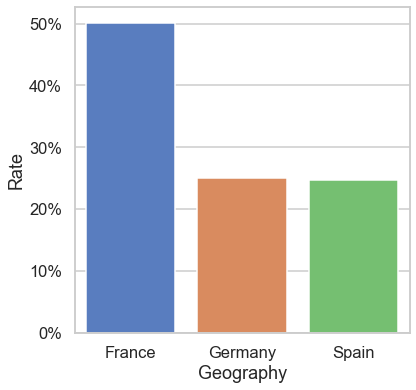

Количество уникальных значений для Gender: 2


,num_value,rate
Gender,,
Male,5457,54.57%
Female,4543,45.43%


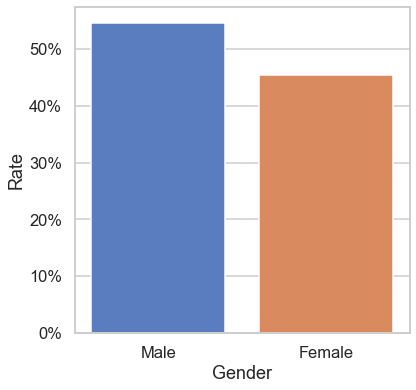

Количество уникальных значений для NumOfProducts: 4


,num_value,rate
NumOfProducts,,
1,5084,50.84%
2,4590,45.90%
3,266,2.66%
4,60,0.60%


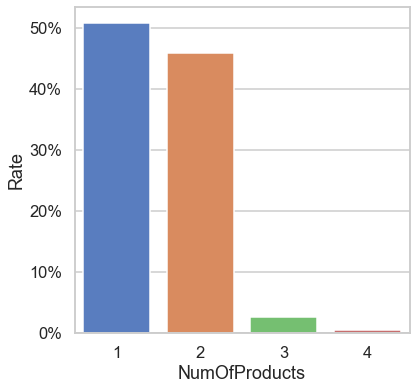

Количество уникальных значений для HasCrCard: 2


,num_value,rate
HasCrCard,,
1,7055,70.55%
0,2945,29.45%


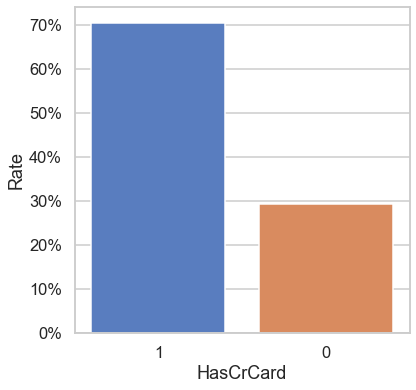

Количество уникальных значений для IsActiveMember: 2


,num_value,rate
IsActiveMember,,
1,5151,51.51%
0,4849,48.49%


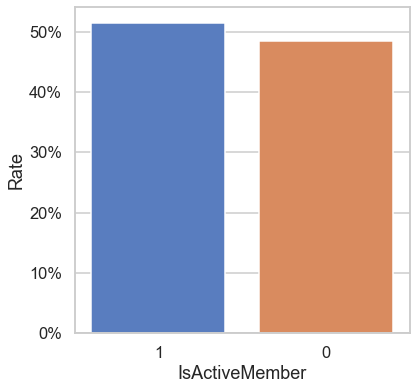

Количество уникальных значений для Exited: 2


,num_value,rate
Exited,,
0,7963,79.63%
1,2037,20.37%


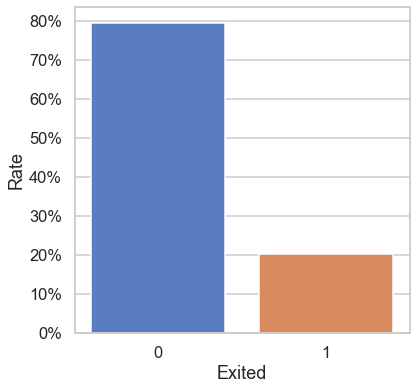

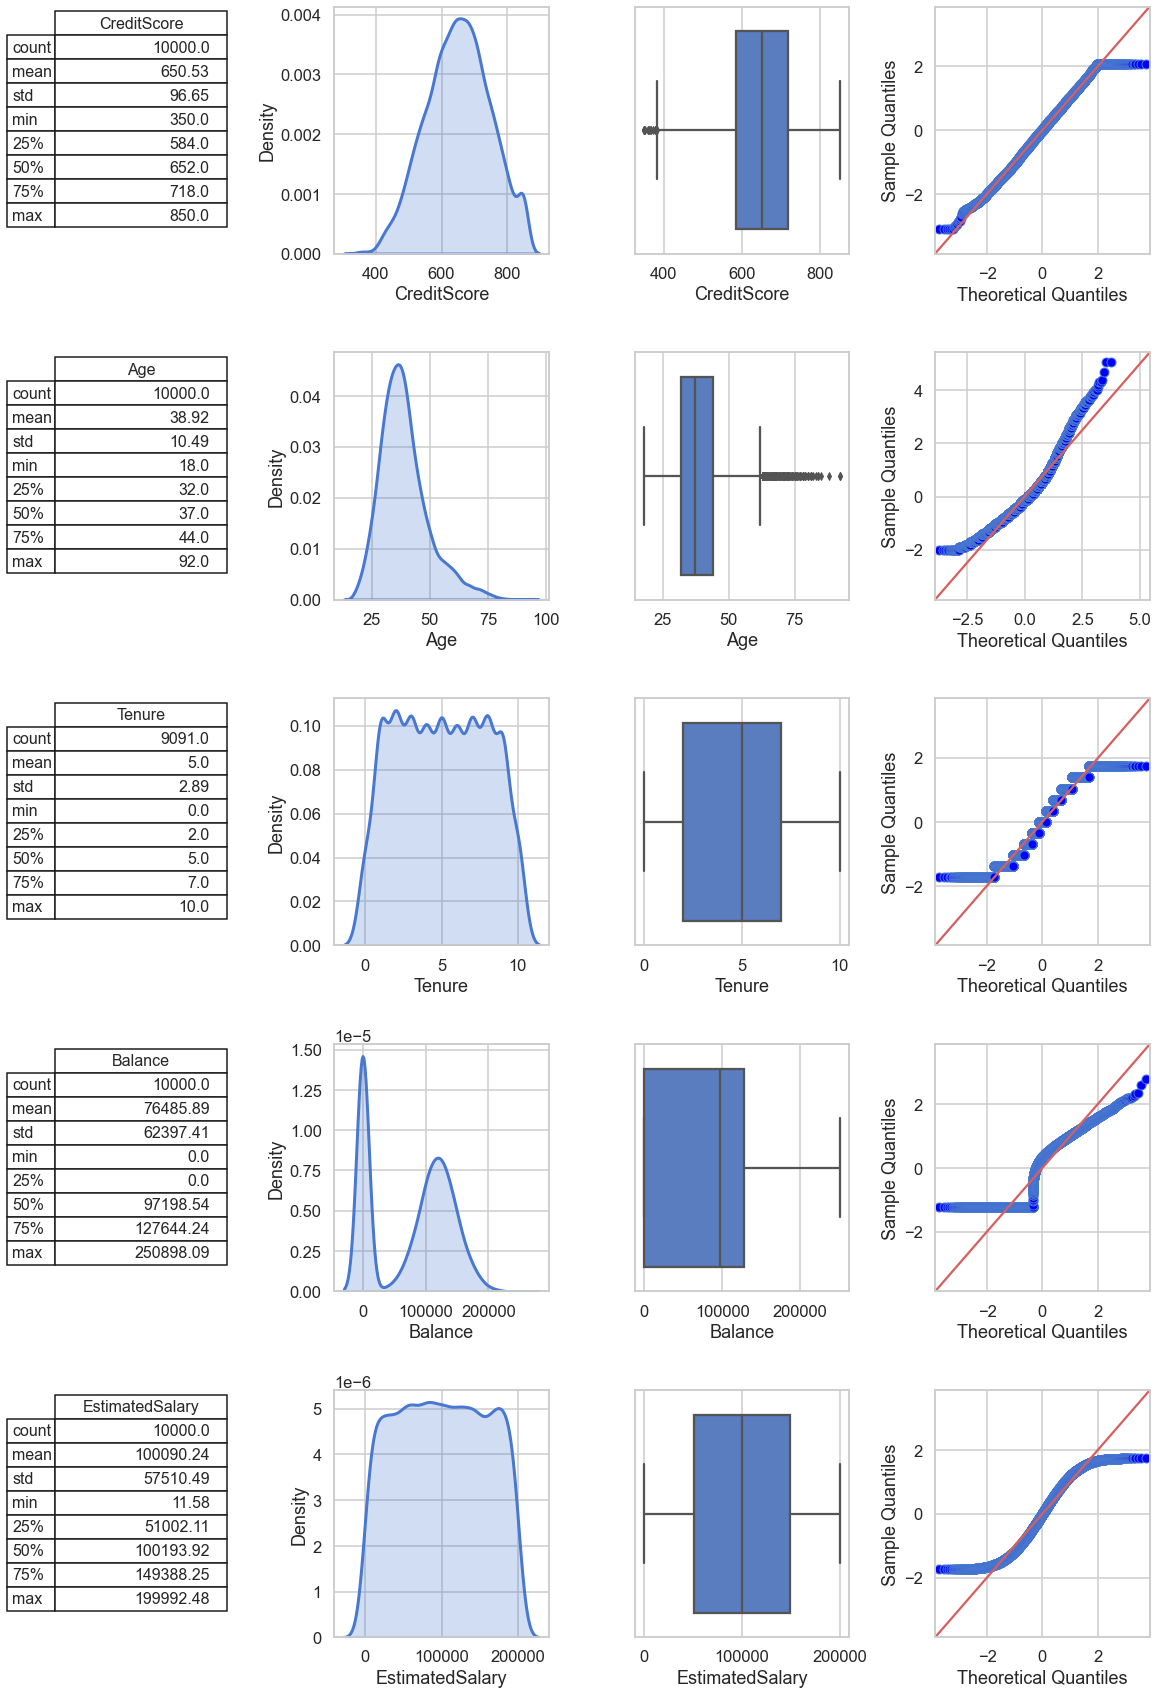

,CreditScore,Age,Tenure,Balance,EstimatedSalary
CreditScore,1.00,-0.00,-0.00,0.01,-0.00
Age,-0.00,1.00,-0.01,0.03,-0.01
Tenure,-0.00,-0.01,1.00,-0.01,0.01
Balance,0.01,0.03,-0.01,1.00,0.01
EstimatedSalary,-0.00,-0.01,0.01,0.01,1.00


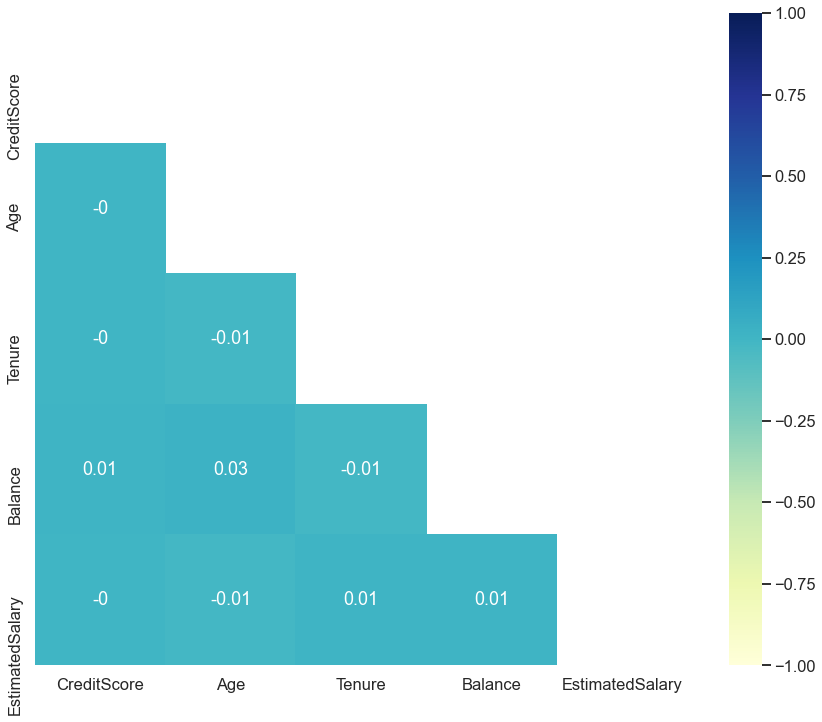

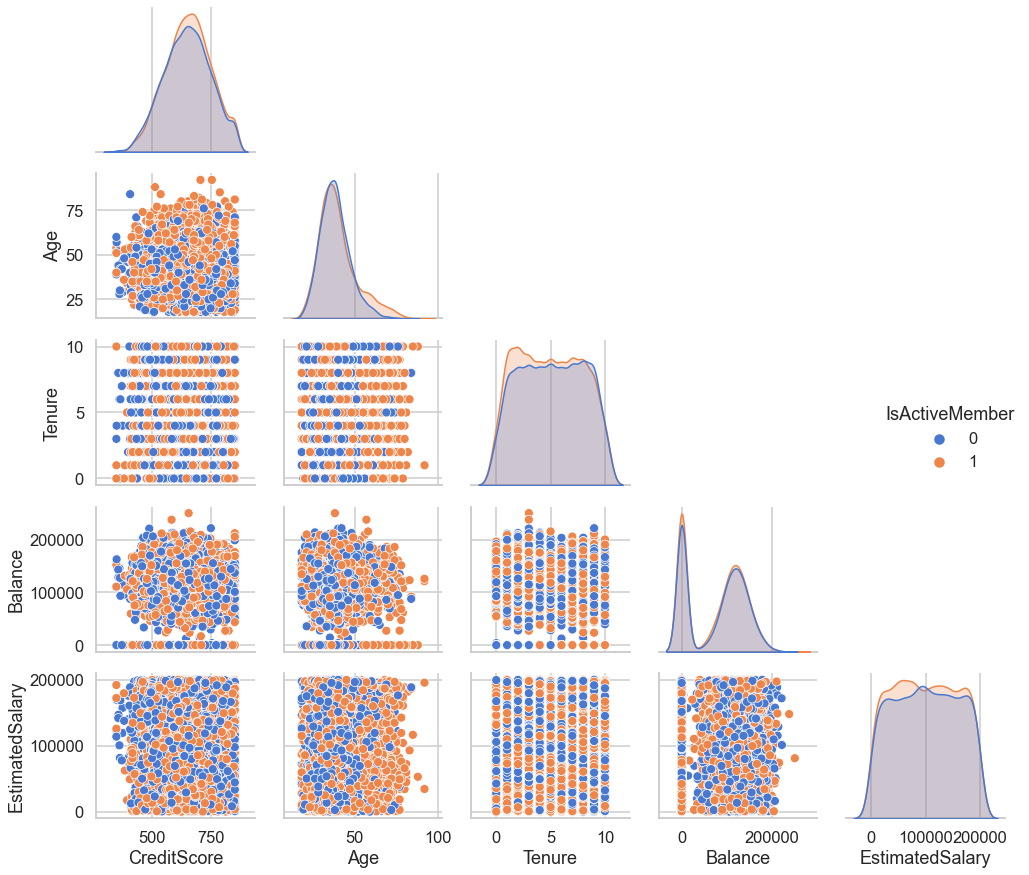

In [18]:
num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
cat_cols = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']

cat_info(data, cols=cat_cols)
num_info(data, cols=num_cols)
num_corr(data, cols=num_cols, hue='IsActiveMember')

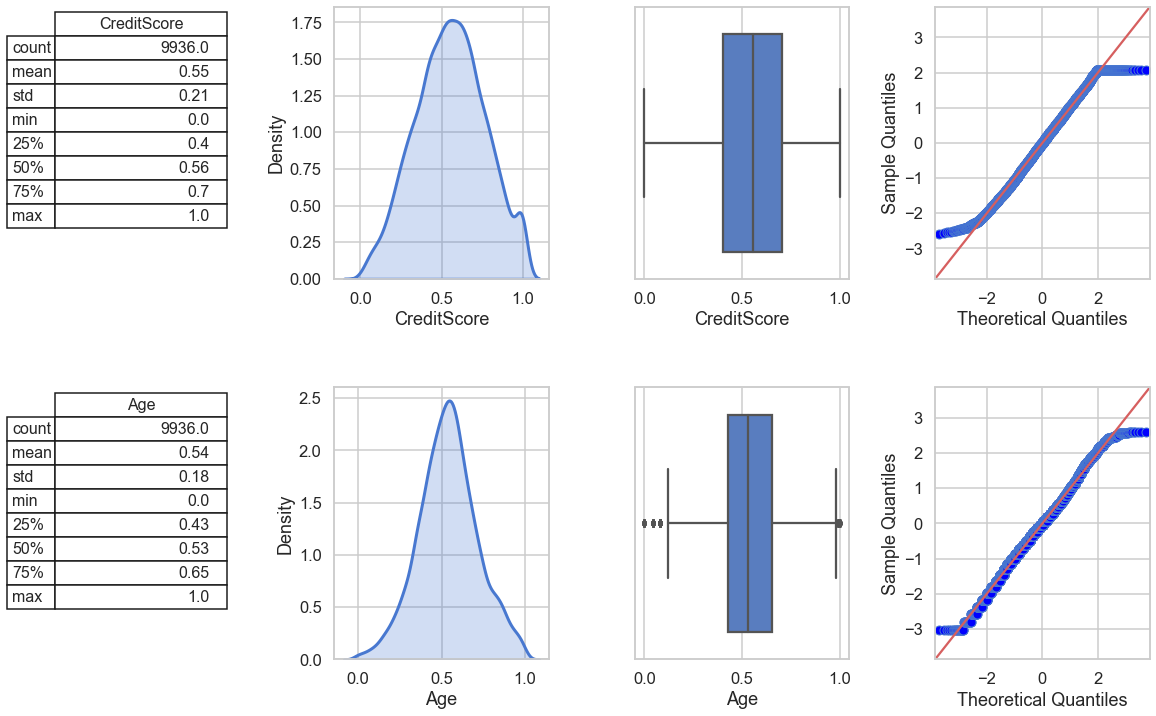

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9936 entries, 0 to 9935
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CreditScore            9936 non-null   float64
 1   Gender                 9936 non-null   int64  
 2   Age                    9936 non-null   float64
 3   Tenure                 9936 non-null   float64
 4   Balance                9936 non-null   float64
 5   HasCrCard              9936 non-null   int64  
 6   IsActiveMember         9936 non-null   int64  
 7   EstimatedSalary        9936 non-null   float64
 8   Exited                 9936 non-null   int64  
 9   Tenure_is_missing      9936 non-null   int64  
 10  NumOfProducts_is_rare  9936 non-null   int64  
 11  Geography_France       9936 non-null   uint8  
 12  Geography_Germany      9936 non-null   uint8  
 13  Geography_Spain        9936 non-null   uint8  
 14  NumOfProducts_1        9936 non-null   uint8  
 15  NumO

In [19]:
data = (data
        
        #Удалить ненужное
        .pipe(drop_data, drop_duplicates=False, columns=['CustomerId', 'Surname'], indexes=None)
        
        #Заполнить пропуски
        .pipe(fill_data, cols=None, group_col=None, strategy='median', fill_value=0, add_indicator=True)
        
        #Заменить редкие категории
        .pipe(mark_rare, cols=['NumOfProducts'], thr=0.03, fill_value='more', add_indicator=True)
        
        #Пометить выбросы
        .pipe(mark_outliers, cols=['CreditScore', 'Age'], min_v=[400, None], max_v=[None, 75], add_indicator=False)
        
        #Удалить выбросы
        .pipe(drop_data)
        
        #Заполнить выбросы
        #.pipe(fill_data, strategy='random', fill_value=0)
        
        #Изменить типы
        .pipe(set_type, cat_cols=cat_cols, int_cols=None, date_cols=None, date_form='%Y-%m-%d')
              
        #Закодировать категориальные
        .pipe(uni_coding, cols=cat_cols, strategy='OHE', drop='if_binary')
              
        #Нормализовать и масштабировать численные
        .pipe(norm_scal, cols=num_cols, norm=True, lmbda=None, scal='minmax')
       )

num_info(data, cols=['CreditScore', 'Age'])
data.info()

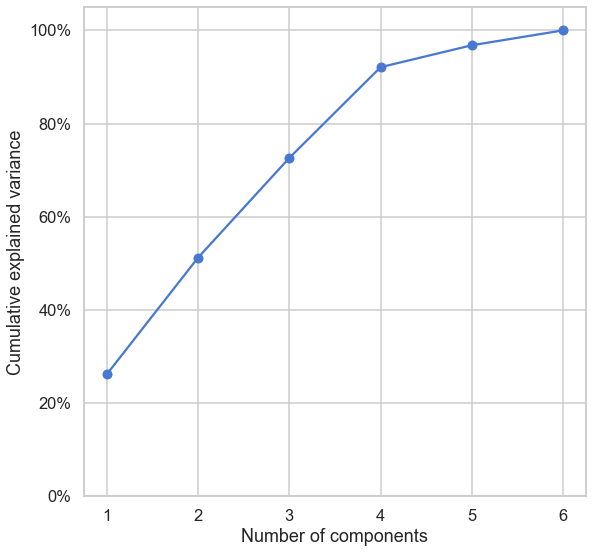

In [20]:
pca_info(data, 
         cols=['CreditScore', 'Age', 'Gender', 'Balance', 'IsActiveMember', 'HasCrCard'], 
         add_pca=False, 
         n_components=None
        )

Четыре компоненты из шести дают больше 90% объясняющей силы. Можно их и добавить.

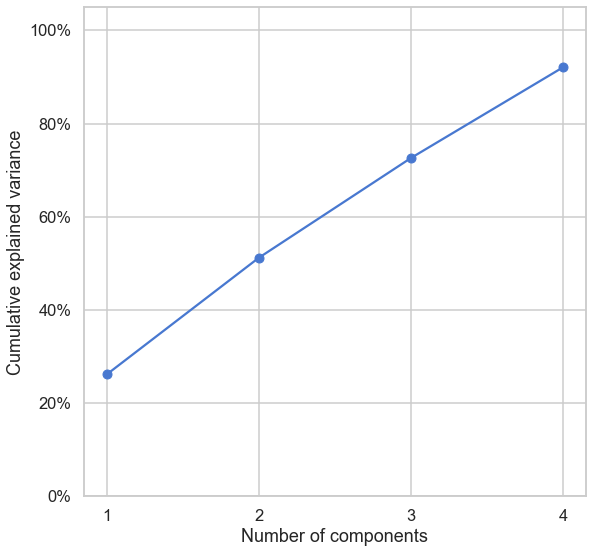

In [21]:
data = pca_info(data, 
         cols=['CreditScore', 'Age', 'Gender', 'Balance', 'IsActiveMember', 'HasCrCard'], 
         add_pca=True, 
         n_components=4
        )

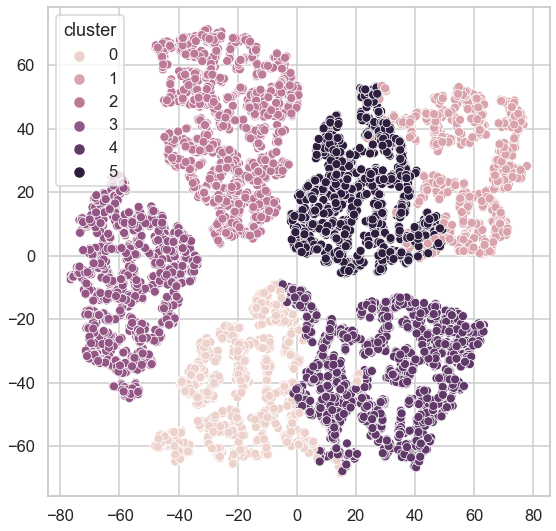

In [22]:
data = cluster_info(data, 
                    cols=['CreditScore', 'Age', 'Tenure', 'Balance', 'Gender'], 
                    add_clusters=True, 
                    n_clusters=6
                   )

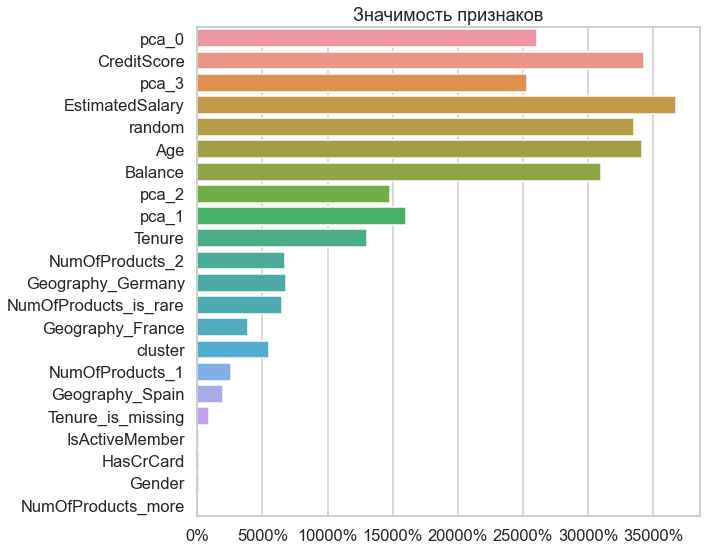

,feature,value,rank
0,pca_0,261,1
1,CreditScore,343,2
2,pca_3,253,3
3,EstimatedSalary,367,4
4,random,335,5
5,Age,341,6
6,Balance,310,7
7,pca_2,148,8
8,pca_1,160,9
9,Tenure,130,10


In [23]:
feature_importances(
    X = data.drop(['Exited'], axis=1), 
    y = data['Exited'], 
    model = LGBMClassifier(random_state=42),
    refit = True,
    random_feature = True
)

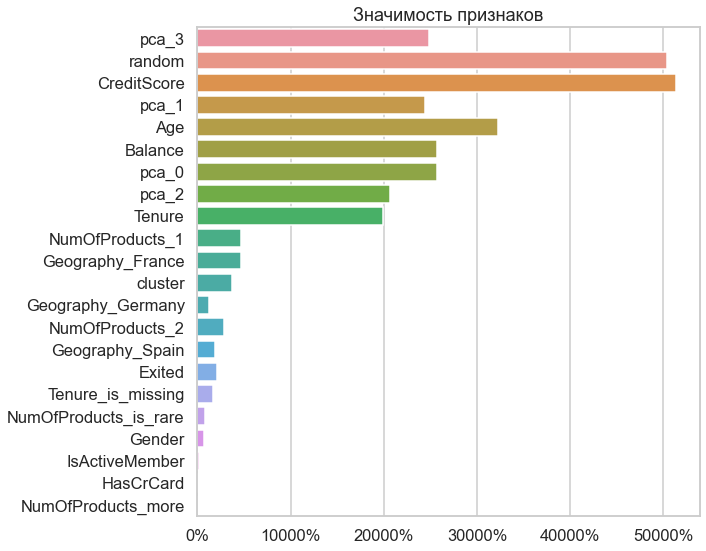

,feature,value,rank
0,pca_3,249,1
1,random,504,2
2,CreditScore,513,3
3,pca_1,244,4
4,Age,322,5
5,Balance,257,6
6,pca_0,257,7
7,pca_2,207,8
8,Tenure,199,9
9,NumOfProducts_1,47,10


In [24]:
feature_importances(
    X = data.drop(['EstimatedSalary'], axis=1), 
    y = data['EstimatedSalary'], 
    model = LGBMRegressor(random_state=42),
    refit = True,
    random_feature = True
)

# 3 Обучение

## 3.1 Предобработка <a class="anchor" id="fifth-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Чтобы не было утечки данных, все расчёты необходимо делать на основе обучающей выборки, а к валидацинной применять только transform. Поэтому часто вместо функций из раздела 1 требуются классы, которые можно включить в пайплайн sklearn перед моделью. Следующие три класса отличаются от стандартных "из коробки" тем, что сохраняют датафрейм в виде датафрейма с информацией о столбцах и индексах. Это удобно при дальнейшем добавлении признаков с помощью KMeans или PCA: можно обращаться по названию столбцов и не задумываться, в каком порядке вернёт признаки трансформер sklearn. Однако расчёты с датафреймами происходят дольше.

In [25]:
class DFOrdinalEncoder():
    def __init__(self, features):
        self.cat_cols = features
        
    def fit(self, X, y=None):
        self.encoder = OrdinalEncoder()
        self.encoder.fit(X[self.cat_cols])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.cat_cols] = self.encoder.transform(X[self.cat_cols])
        return X

In [26]:
class DFStandardScaler():
    def __init__(self, features):
        self.num_cols = features
        
    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.num_cols])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.num_cols] = self.scaler.transform(X[self.num_cols])
        return X

In [27]:
class DFMinMaxScaler():
    def __init__(self, features):
        self.num_cols = features
        
    def fit(self, X, y=None):
        self.scaler = MinMaxScaler()
        self.scaler.fit(X[self.num_cols])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.num_cols] = self.scaler.transform(X[self.num_cols])
        return X

С помощью функций pca_info и cluster_info можно перебрать разные варианты, а финальные идеи реализовывать уже через fit и transform.

In [28]:
class AddCluster():
    def __init__(self, cluster_features, n_clusters, cluster_name):
        self.cluster_features = cluster_features
        self.n_clusters = n_clusters
        self.cluster_name = cluster_name
        
    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=50, random_state=42)
        self.kmeans.fit(X[self.cluster_features])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X[self.cluster_name] = self.kmeans.predict(X[self.cluster_features])
        return X

In [29]:
class AddPCA():
    def __init__(self, pca_features, n_components, pca_prefix='PCA'):
        self.pca_features = pca_features
        self.n_components = n_components
        self.pca_prefix = pca_prefix
        
    def fit(self, X, y=None):
        self.pca = PCA(n_components=self.n_components, random_state=42)
        self.pca.fit(X[self.pca_features])
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X_pca = self.pca.transform(X[self.pca_features])
        component_names = [self.pca_prefix + '_' + str(i) for i in range(X_pca.shape[1])]
        X = X.join(pd.DataFrame(X_pca, index=X.index, columns=component_names))
        return X

Загрузим данные заново. Расчёты по всем объектам (mean, max, min) до деления на обучающую и валидационную выборку проводить не будем.

In [30]:
data = pd.read_csv(link, index_col = 0)

num_cols = ['CreditScore', 'Age', 'Tenure', 'Balance']
cat_cols = ['Geography', 'Gender']

data = (data
        .pipe(drop_data, drop_duplicates=False, columns=['CustomerId', 'Surname'], indexes=None)
        .pipe(fill_data, cols=None, group_col=None, strategy='constant', fill_value=0, add_indicator=True)
        .pipe(mark_outliers, cols=['CreditScore', 'Age'], min_v=[400, None], max_v=[None, 75], add_indicator=False)
        .pipe(drop_data)
        .pipe(set_type, cat_cols=cat_cols, int_cols=None, date_cols=None, date_form='%Y-%m-%d')
        .pipe(norm_scal, cols=num_cols, norm=True, lmbda=None, scal=None)
        .pipe(norm_scal, cols=['EstimatedSalary'], norm=True, lmbda=0, scal=None)
       )

pca0_cols = ['CreditScore', 'Age', 'Gender', 'Balance', 'IsActiveMember', 'HasCrCard']
clust0_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'Gender']

Всё, что требует fit и transform, теперь в отдельном пайплайне.

In [31]:
def get_pipline(model):
    '''
    Создаёт пайплайн: масштабирование числовых признаков, кодирование категориальных, кластеризация, PCA и модель.
    Функция на ручном управлении: нужно вписать признаки, ненужные действия можно закомментить.
    '''
    return Pipeline(
        steps=[
            ('encoder', DFOrdinalEncoder(cat_cols)),
            
            #Нужно выбрать один scaler
            ('scaler', DFMinMaxScaler(num_cols)),
#             ('scaler', DFStandardScaler(num_cols)),
            
            ('cluster0', AddCluster(
                clust0_cols,
                n_clusters = 6,
                cluster_name = 'cluster0')),
            
            #Можно добавлять несколько разных
#             ('cluster1', AddCluster(
#                 clust1_cols,
#                 n_clusters = 5,
#                 cluster_name = 'cluster1')),
            
            ('pca0', AddPCA(
                pca0_cols,
                n_components = 4,
                pca_prefix = 'PCA0')),
            
#             ('pca1', AddPCA(
#                 pca1_cols,
#                 n_components=2,
#                 pca_prefix='PCA1')),
            
            ('model', model)
        ]
    )

## 3.2 Регрессия <a class="anchor" id="sixth-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Для примера рассмотрим метрику RMSE и кросс-валидацию.

In [32]:
def score_dataset(model, X, y):
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    score = abs(cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf).mean())
    return score

Переберём разные модели.

In [33]:
def models_score(X, y):
    models = [
        ('DummyRegressor', DummyRegressor(strategy='mean')),
        ('LinearRegression', LinearRegression()),
        ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
        ('LGBMRegressor', LGBMRegressor(random_state=42))
    ]
    
    for model_name, model in models:
        pipeline = get_pipline(model)
        print('{}: RMSE = {:.3f}'.format(model_name, score_dataset(pipeline, X, y)))

In [34]:
X = data.drop(['EstimatedSalary'], axis=1)
y = data['EstimatedSalary']

models_score(X, y)

DummyRegressor: RMSE = 1.001
LinearRegression: RMSE = 1.001
RandomForestRegressor: RMSE = 1.047
LGBMRegressor: RMSE = 1.023


Подберём гиперпараметры.

In [35]:
%%time

def objective(trial):
    '''
    Возвращает значение метрики на кросс-валидации.
    Модель: LGBMRegressor
    '''
    model = LGBMRegressor(
        num_leaves = trial.suggest_int('num_leaves', 2, 1500),
        n_estimators = trial.suggest_int('n_estimators', 100, 1500), 
        max_depth = trial.suggest_int('max_depth', 2, 25), 
        min_child_samples = trial.suggest_int('min_child_samples', 2, 3000), 
        learning_rate = trial.suggest_uniform('learning_rate', 0.00001, 0.09),
        random_state = 42,
        n_jobs = -1
    )
    pipeline = get_pipline(model)
    return score_dataset(pipeline, X, y)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
lgbm_params = study.best_params

[I 2021-10-01 17:59:21,310] A new study created in memory with name: no-name-f175b0d8-2cb5-4762-aa6c-ead919f0f510
[I 2021-10-01 17:59:24,766] Trial 0 finished with value: 1.000872540773256 and parameters: {'num_leaves': 712, 'n_estimators': 366, 'max_depth': 4, 'min_child_samples': 2544, 'learning_rate': 0.003554299015495591}. Best is trial 0 with value: 1.000872540773256.
[I 2021-10-01 17:59:27,951] Trial 1 finished with value: 1.0014724611693258 and parameters: {'num_leaves': 219, 'n_estimators': 181, 'max_depth': 21, 'min_child_samples': 2360, 'learning_rate': 0.04159228350435329}. Best is trial 0 with value: 1.000872540773256.
[I 2021-10-01 17:59:30,892] Trial 2 finished with value: 1.0011937068725552 and parameters: {'num_leaves': 716, 'n_estimators': 161, 'max_depth': 3, 'min_child_samples': 2705, 'learning_rate': 0.06141635469788298}. Best is trial 0 with value: 1.000872540773256.
[I 2021-10-01 17:59:35,134] Trial 3 finished with value: 1.0024001064728791 and parameters: {'num_l

CPU times: user 21min 40s, sys: 2min 22s, total: 24min 2s
Wall time: 1min 35s


In [36]:
pipeline = get_pipline(LGBMRegressor(random_state=42, **lgbm_params))
pipeline.fit(X,y);

## 3.3 Классификация <a class="anchor" id="seventh-bullet"></a>

### Новигация

* [Содержание](#zeroth-bullet)
* [1.1 Загрузка данных](#first-bullet)
* [1.2 Предобработка данных](#second-bullet)
* [1.3 Подготовка признаков](#third-bullet)
* [2 Пайплайн](#fourth-bullet)
* [3.1 Предобработка](#fifth-bullet)
* [3.2 Регрессия](#sixth-bullet)
* [3.3 Классификация](#seventh-bullet)

Аналогичный пример для классификации и F1.

In [37]:
def score_dataset(model, X, y):
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    score = cross_val_score(model, X, y, scoring='f1', cv=kf).mean()
    return score

In [38]:
def models_score(X, y):
    models = [
        ('DummyClassifier', DummyClassifier(strategy='stratified', random_state=42)),
        ('LogisticRegression', LogisticRegression(solver='liblinear', random_state=42)),
        ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
        ('LGBMClassifier', LGBMClassifier(random_state=42))
    ]
    
    for model_name, model in models:
        pipeline = get_pipline(model)
        print('{}: F1 = {:.3f}'.format(model_name, score_dataset(pipeline, X, y)))

In [39]:
X = data.drop(['Exited'], axis=1)
y = data['Exited']

models_score(X, y)

DummyClassifier: F1 = 0.204
LogisticRegression: F1 = 0.311
RandomForestClassifier: F1 = 0.557
LGBMClassifier: F1 = 0.586


In [40]:
%%time

def objective(trial):
    '''
    Возвращает значение метрики на кросс-валидации.
    Модель: LGBMRegressor
    '''
    model = LGBMClassifier(
        num_leaves = trial.suggest_int('num_leaves', 2, 1500),
        n_estimators = trial.suggest_int('n_estimators', 100, 1500), 
        max_depth = trial.suggest_int('max_depth', 2, 25), 
        min_child_samples = trial.suggest_int('min_child_samples', 2, 3000), 
        learning_rate = trial.suggest_uniform('learning_rate', 0.00001, 0.09),
        class_weight = trial.suggest_categorical('class_weight', ['balanced', None]),
        random_state = 42,
        n_jobs = -1
    )
    pipeline = get_pipline(model)
    return score_dataset(pipeline, X, y)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
lgbm_params = study.best_params

[I 2021-10-01 18:01:13,886] A new study created in memory with name: no-name-04a25dd7-265c-4660-b1b5-9c70f2e44ccd
[I 2021-10-01 18:01:18,289] Trial 0 finished with value: 0.5326898118515284 and parameters: {'num_leaves': 1315, 'n_estimators': 613, 'max_depth': 24, 'min_child_samples': 1201, 'learning_rate': 0.030205515858342954, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.5326898118515284.
[I 2021-10-01 18:01:22,779] Trial 1 finished with value: 0.48591469589921604 and parameters: {'num_leaves': 983, 'n_estimators': 961, 'max_depth': 8, 'min_child_samples': 1404, 'learning_rate': 0.0442456689882587, 'class_weight': None}. Best is trial 0 with value: 0.5326898118515284.
[I 2021-10-01 18:01:27,773] Trial 2 finished with value: 0.486444290111848 and parameters: {'num_leaves': 553, 'n_estimators': 1444, 'max_depth': 4, 'min_child_samples': 1428, 'learning_rate': 0.07780414423067916, 'class_weight': None}. Best is trial 0 with value: 0.5326898118515284.
[I 2021-10-01 18:01:31

CPU times: user 27min 20s, sys: 2min 22s, total: 29min 42s
Wall time: 1min 56s


In [41]:
pipeline = get_pipline(LGBMClassifier(random_state=42, **lgbm_params))
pipeline.fit(X,y);